# Cubic Interpolation with Scipy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicHermiteSpline

from HARK.interpolation import CubicInterp, CubicHermiteInterp

### Creating a HARK wrapper for scipy's CubicHermiteSpline

The class CubicHermiteInterp in HARK.interpolation implements a HARK wrapper for scipy's CubicHermiteSpline. A HARK wrapper is needed due to the way interpolators are used in solution methods accross HARK, and in particular due to the `distance_criteria` attribute used for VFI convergence. 

In [2]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-(x ** 2) / 9.0)
dydx = 2.0 * x / 9.0 * np.sin(-(x ** 2) / 9.0)

f = CubicInterp(x, y, dydx, lower_extrap=True)
f2 = CubicHermiteSpline(x, y, dydx)
f3 = CubicHermiteInterp(x, y, dydx, lower_extrap=True)

Above are 3 interpolators, which are:
1. **CubicInterp** from HARK.interpolation
2. **CubicHermiteSpline** from scipy.interpolate
3. **CubicHermiteInterp** hybrid newly implemented in HARK.interpolation

Below we see that they behave in much the same way.

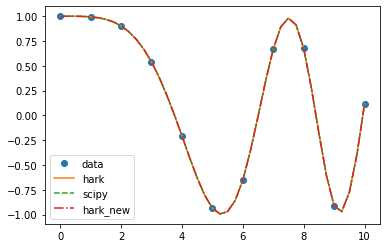

In [3]:
xnew = np.linspace(0, 10, num=41, endpoint=True)

plt.plot(x, y, "o", xnew, f(xnew), "-", xnew, f2(xnew), "--", xnew, f3(xnew), "-.")
plt.legend(["data", "hark", "scipy", "hark_new"], loc="best")
plt.show()

We can also verify that **CubicHermiteInterp** works as intended when extrapolating. Scipy's **CubicHermiteSpline** behaves differently when extrapolating, as it extrapolates using the last polynomial, whereas HARK implements linear decay extrapolation, so it is not shown below.

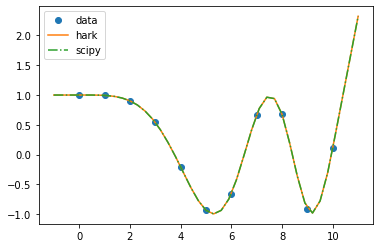

In [4]:
x_out = np.linspace(-1, 11, num=41, endpoint=True)

plt.plot(x, y, "o", x_out, f(x_out), "-", x_out, f3(x_out), "-.")
plt.legend(["data", "hark", "scipy", "hark_new"], loc="best")
plt.show()

### Timings

Below we can compare timings for interpolation and extrapolation among the 3 interpolators. As expected, `scipy`'s CubicHermiteInterpolator (`f2` below) is the fastest, but it's not HARK compatible. `HARK.interpolation`'s CubicInterp (`f`) is the slowest, and `HARK.interpolation`'s new CubicHermiteInterp (`f3`) is somewhere in between. 

In [5]:
%timeit f(xnew)
%timeit f(x_out)

44.4 µs ± 858 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
46.6 µs ± 977 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
%timeit f2(xnew)
%timeit f2(x_out)

9.2 µs ± 650 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.3 µs ± 749 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%timeit f3(xnew)
%timeit f3(x_out)

21.2 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
36.9 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Notice in particular
the
difference
between
interpolating and extrapolating for the new ** CubicHermiteInterp **.The difference comes from having to calculate the extrapolation "by hand", since `HARK` uses linear decay extrapolation, whereas for interpolation it returns `scipy`'s result directly.

### Additional features from `scipy`

Since we are using `scipy`'s **CubicHermiteSpline** already, we can add a few new features to `HARK.interpolation`'s new **CubicHermiteInterp** without much effort. These include:

1. `der_interp(self[, nu])` Construct a new piecewise polynomial representing the derivative.
2. `antider_interp(self[, nu])` Construct a new piecewise polynomial representing the antiderivative.
3. `integrate(self, a, b[, extrapolate])` Compute a definite integral over a piecewise polynomial.
4. `roots(self[, discontinuity, extrapolate])` Find real roots of the the piecewise polynomial.
5. `solve(self[, y, discontinuity, extrapolate])` Find real solutions of the the equation pp(x) == y.

In [8]:
integral_1 = f3.integrate(a=0, b=10)
integral_2 = f3.integrate(a=2, b=8)
antiderivative = f3.antider_interp()
integral_11 = antiderivative(10) - antiderivative(0)
integral_21 = antiderivative(8) - antiderivative(2)

First, we evaluate integration and the antiderivative. Below, we see the numerical integral between 0 and 10 using `integrate` or the `antiderivative` directly. The actual solution is `~1.43325`. 

In [9]:
integral_1, integral_11

(array(1.45065298), 1.4506529836496944)

The value of the integral between 2 and 8 is `~0.302871`.

In [10]:
integral_2, integral_21

(array(0.29782427), 0.2978242700564402)

### `roots` and `solve`

We evaluate these graphically, by finding zeros, and by finding where the function equals `0.5`.

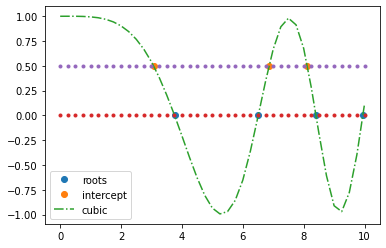

In [11]:
roots = f3.roots(extrapolate=False)
intercept = f3.solve(y=0.5, extrapolate=False)

plt.plot(roots, np.zeros(roots.size), "o")
plt.plot(intercept, np.repeat(0.5, intercept.size), "o")
plt.plot(xnew, f3(xnew), "-.")
plt.legend(["roots", "intercept", "cubic"], loc="best")
plt.plot(xnew, np.zeros(xnew.size), ".")
plt.plot(xnew, np.ones(xnew.size) * 0.5, ".")
plt.show()